In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from src.data_loader import load_and_align_prices
from src.stats import estimate_hedge_ratio, compute_spread, estimate_rolling_hedge_ratio
from src.strategy import (
    compute_zscore,
    generate_signals,
    position_from_signal,
    apply_capped_volatility_scaling,
)
from src.backtester import backtest_pairs_strategy, calculate_performance_metrics


In [3]:
prices = load_and_align_prices(
    "../data/gold.csv",
    "../data/silver.csv"
)

with open("../results/statistical_summary.json", "r") as f:
    stats = json.load(f)

hedge_ratio = stats["hedge_ratio"]
half_life = stats["half_life_days"]

hedge_ratio, half_life


(0.8398666970367117, 69.69837286756666)

In [4]:
spread = compute_spread(
    prices["gold"],
    prices["silver"],
    hedge_ratio
)

spread = spread.dropna()
prices = prices.loc[spread.index]

spread.head()


timestamp
2015-01-02 00:00:00+05:30   -3702.569767
2015-01-05 00:00:00+05:30   -4058.904324
2015-01-06 00:00:00+05:30   -4448.705951
2015-01-07 00:00:00+05:30   -4554.046214
2015-01-08 00:00:00+05:30   -4235.433922
dtype: float64

In [5]:
z_window = int(half_life)  # ≈ 70
zscore = compute_zscore(spread, z_window)

In [6]:
entry_z = 2.0
exit_z = 0.5

signal = generate_signals(
    zscore,
    entry_z,
    exit_z
)

position = position_from_signal(signal)

position = apply_capped_volatility_scaling(
    position,
    spread,
    vol_window=z_window,
    min_scale=0.5,
    max_scale=1.5
)


/Users/tanmaygarg/Desktop/gold_silver_strategy/src/strategy.py:46: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = signal.replace(to_replace=0, method="ffill")


In [7]:
transaction_cost = 0.0001

bt = backtest_pairs_strategy(
    prices,
    position,
    hedge_ratio,
    transaction_cost
)


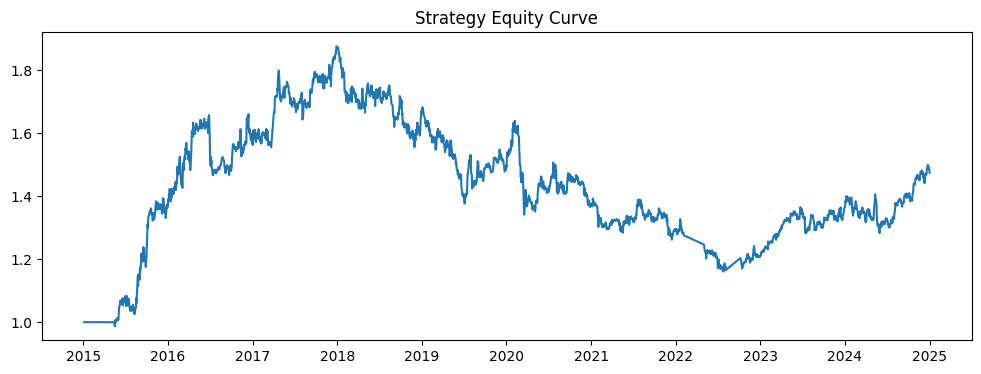

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(bt["equity_curve"])
plt.title("Strategy Equity Curve")
plt.savefig("../results/figures/equity_curve.png",
            dpi=300, bbox_inches="tight")

plt.show()


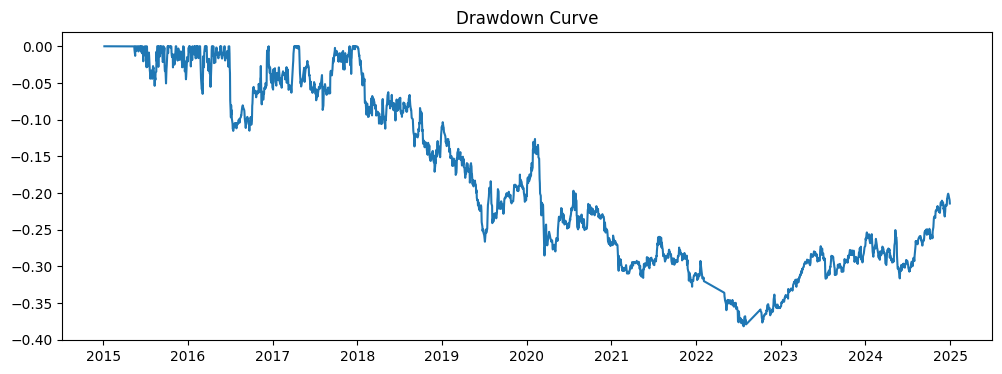

In [9]:
equity = bt["equity_curve"]
peak = equity.cummax()
drawdown = (equity - peak) / peak

plt.figure(figsize=(12, 4))
plt.plot(drawdown)
plt.title("Drawdown Curve")
plt.savefig("../results/figures/drawdown.png",
            dpi=300, bbox_inches="tight")

plt.show()


In [10]:
metrics = calculate_performance_metrics(
    bt["strategy_return"].dropna(),
    periods_per_year=252
)

metrics

{'Total Return': np.float64(0.4747489422179676),
 'Annualized Return': np.float64(0.040632486973328996),
 'Sharpe Ratio': np.float64(0.3219509913218485),
 'Max Drawdown': np.float64(-0.3815026189252653),
 'Calmar Ratio': np.float64(0.10650644309545021)}

In [11]:
returns = bt["strategy_return"].dropna()

# Sortino Ratio
downside = returns[returns < 0]
sortino_ratio = returns.mean() / downside.std() * np.sqrt(252)

# Win Rate
win_rate = (returns > 0).mean()

# Total Trades
total_trades = (position.diff().abs() > 0).sum()

# Trade Durations
trade_durations = (
    position.ne(position.shift())
    .cumsum()
    .groupby(position.ne(position.shift()).cumsum())
    .size()
)
average_trade_duration = trade_durations.mean()

# Largest Win / Loss
largest_win = returns.max()
largest_loss = returns.min()

{
    "Sortino Ratio": sortino_ratio,
    "Win Rate": win_rate,
    "Total Trades": total_trades,
    "Average Trade Duration (days)": average_trade_duration,
    "Largest Win": largest_win,
    "Largest Loss": largest_loss
}


{'Sortino Ratio': np.float64(0.5511329539153176),
 'Win Rate': np.float64(0.4882017900732303),
 'Total Trades': np.int64(1319),
 'Average Trade Duration (days)': np.float64(1.8628787878787878),
 'Largest Win': np.float64(0.06934726163018776),
 'Largest Loss': np.float64(-0.04406371484357177)}

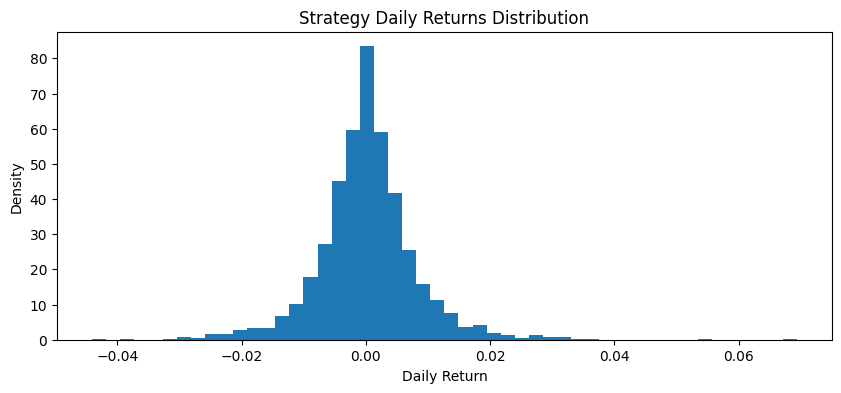

In [12]:
import matplotlib.pyplot as plt

returns = bt["strategy_return"].dropna()

plt.figure(figsize=(10,4))
plt.hist(returns, bins=50, density=True)
plt.title("Strategy Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.savefig("../results/figures/strategy_returns_distribution.png",
            dpi=300, bbox_inches="tight")
plt.show()


/var/folders/yn/76dpdzns7qjb99gkpmrwsk3r0000gn/T/ipykernel_57720/2006148639.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


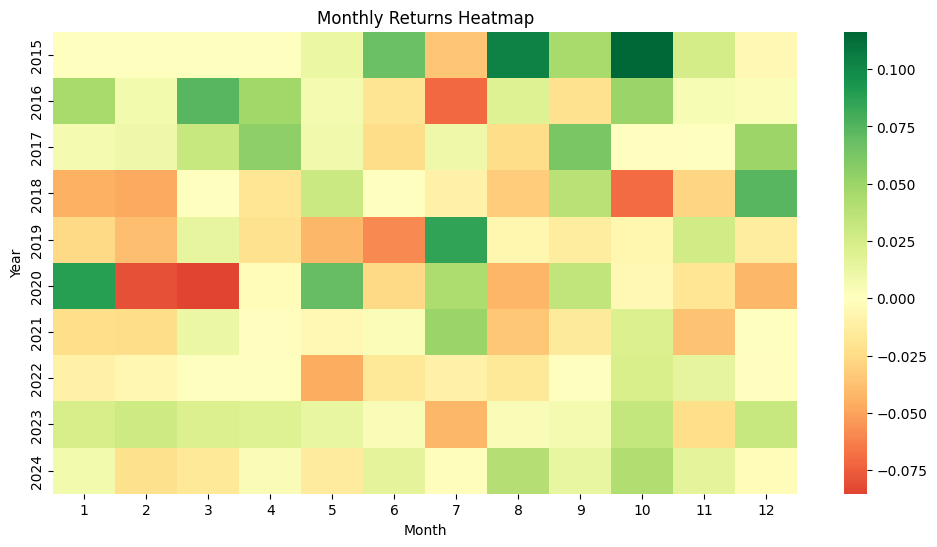

In [13]:
import seaborn as sns
import pandas as pd

monthly_returns = (
    returns
    .resample("M")
    .apply(lambda x: (1 + x).prod() - 1)
)

heatmap_data = monthly_returns.to_frame("return")
heatmap_data["Year"] = heatmap_data.index.year
heatmap_data["Month"] = heatmap_data.index.month

pivot = heatmap_data.pivot(
    index="Year",
    columns="Month",
    values="return"
)

plt.figure(figsize=(12,6))
sns.heatmap(
    pivot,
    cmap="RdYlGn",
    center=0,
    annot=False
)
plt.title("Monthly Returns Heatmap")
plt.savefig("../results/figures/monthly_returns_heatmap.png",
            dpi=300, bbox_inches="tight")
plt.show()


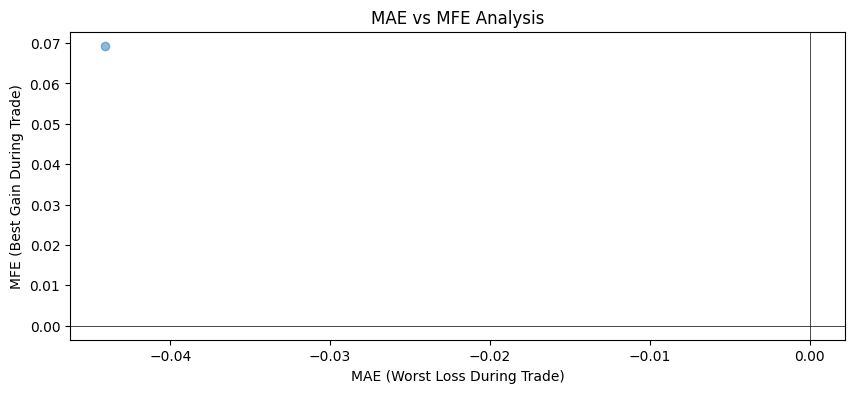

In [14]:
trade_returns = bt["strategy_return"].copy()
in_trade = position != 0

mae = trade_returns[in_trade].groupby(
    (in_trade != in_trade.shift()).cumsum()
).min()

mfe = trade_returns[in_trade].groupby(
    (in_trade != in_trade.shift()).cumsum()
).max()

plt.figure(figsize=(10,4))
plt.scatter(mae, mfe, alpha=0.5)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlabel("MAE (Worst Loss During Trade)")
plt.ylabel("MFE (Best Gain During Trade)")
plt.title("MAE vs MFE Analysis")
plt.savefig("../results/figures/mae_mfe.png",
            dpi=300, bbox_inches="tight")
plt.show()


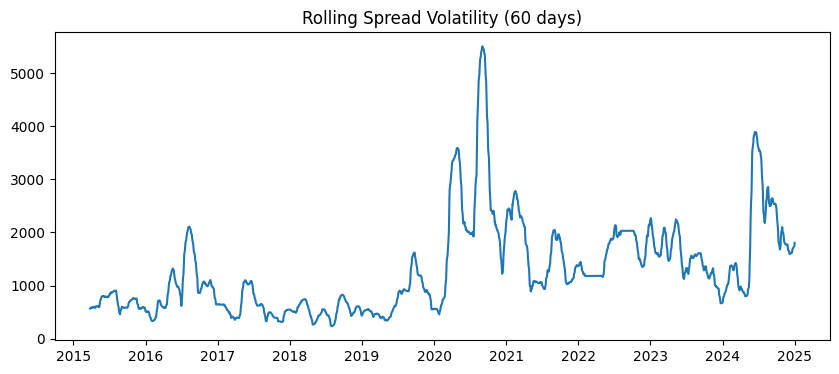

In [15]:
rolling_vol = spread.rolling(60).std()

plt.figure(figsize=(10,4))
plt.plot(rolling_vol)
plt.title("Rolling Spread Volatility (60 days)")
plt.savefig("../results/figures/spread_volatility.png",
            dpi=300, bbox_inches="tight")
plt.show()
